### utils

In [1]:
import pandas as pd
import torch, torch_geometric
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.nn import MSELoss
import copy
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import joblib
import re
from sklearn.neighbors import BallTree
from sklearn.metrics import pairwise_distances
from torch_geometric.nn import NNConv
from torch_geometric.typing import Adj
from torch_geometric.nn import RGCNConv
from torch.optim import AdamW
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from hangul_romanize import Transliter
from hangul_romanize.rule import academic
import matplotlib
import optuna

/home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/torch_spline_con

### io

In [2]:
# data
df = pd.read_csv("/home/khs/data/csv/matching data/chla_sentinel2_trans.csv")
print(len(df))
df

881


,분류번호,측정소명,년/월/일,회차,경도,위도,채수시각,수심(m),수온(℃),클로로필 a(㎎/㎥),...,B4,B5,B6,B7,B8,B8A,B9,SCL,idx,image_id_S2
0,5003B20,나주댐1,2018/02/22,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,NaN,2.9,9.3,...,245.0,239.0,225.0,243.0,249.0,220.0,195.0,6.0,963,20180222T021709_20180222T021703_T52SBD
1,5003B10,나주댐2,2018/02/22,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:23,NaN,3.7,8.3,...,511.0,629.0,590.0,628.0,712.0,556.0,473.0,6.0,964,20180222T021709_20180222T021703_T52SBD
2,5003B20,나주댐1,2018/02/22,1회차 중층부,"126°51'36""","34°57'22.39""",11:15,NaN,3.6,8.6,...,245.0,239.0,225.0,243.0,249.0,220.0,195.0,6.0,967,20180222T021709_20180222T021703_T52SBD
3,5003B20,나주댐1,2018/02/22,1회차 하층부,"126°51'36""","34°57'22.39""",11:11,NaN,3.6,8.2,...,245.0,239.0,225.0,243.0,249.0,220.0,195.0,6.0,969,20180222T021709_20180222T021703_T52SBD
4,2018B30,남강댐1(진양호),2018/10/15,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,40.98,17.7,4.5,...,832.0,645.0,172.0,154.0,125.0,79.0,0.0,6.0,5034,20181015T021641_20181015T022428_T52SDD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,4007B70,주암댐1,2025/10/28,3회차 상층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,21.2,6.0,...,76.0,66.0,51.0,52.0,49.0,62.0,69.0,6.0,38663,20251028T021821_20251028T022504_T52SCD
877,4007B70,주암댐1,2025/10/28,3회차 중층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,20.0,5.8,...,76.0,66.0,51.0,52.0,49.0,62.0,69.0,6.0,38664,20251028T021821_20251028T022504_T52SCD
878,4007B70,주암댐1,2025/10/28,3회차 하층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,12.7,0.4,...,76.0,66.0,51.0,52.0,49.0,62.0,69.0,6.0,38665,20251028T021821_20251028T022504_T52SCD
879,5001B40,광주댐1,2025/11/07,1회차,"126°59'9.6""","35°11'59.14""",13:57,NaN,18.5,5.3,...,217.0,157.0,75.0,58.0,78.0,61.0,35.0,6.0,38961,20251107T021911_20251107T022008_T52SCD


In [3]:
# 고유 측정소 리스트 확인
unique_stations = df["측정소명"].unique().tolist()

print("측정소 리스트 (총 {}개):".format(len(unique_stations)))
print(unique_stations)

측정소 리스트 (총 80개):
['나주댐1', '나주댐2', '남강댐1(진양호)', '남강댐2(진양호)', '남강댐3(진양호)', '춘천댐1', '충주댐1', '장흥댐2', '장흥댐3', '장흥댐4', '주암댐1', '군위댐1', '군위댐2', '수어댐1', '주암조정지댐1(상사호)', '주암조정지댐3(상사호)', '보성강댐1', '보성강댐2', '장흥댐1', '장성댐1', '장성댐2', '화천댐1(파로호)', '괴산댐3', '대청댐4', '대청댐6', '합천댐1', '합천댐2', '대청댐1', '연초댐2', '주암댐2', '주암댐3', '김천부항댐', '부안댐1', '부안댐2', '부안댐3', '임하댐1', '임하댐2', '광동댐', '보령댐3', '소양강댐2', '소양강댐3', '보현산댐', '합천댐3', '광주댐1', '광주댐2', '대청댐3', '회야호1', '회야호2', '충주댐2', '충주댐3', '충주댐4', '구천댐', '화천댐2(파로호)', '화천댐3(파로호)', '충주조정지댐2', '달방댐', '영천댐1(영천호)', '청평댐2', '청평댐3', '가창댐1', '섬진강댐1(옥정호)', '의암댐1', '보령댐1', '보령댐2', '도암댐', '군남댐', '한탄강댐', '담양댐1', '담양댐2', '대청댐2', '연초댐1', '영천댐2(영천호)', '용담댐3', '팔당댐5', '팔당댐1', '팔당댐2', '팔당댐3', '팔당댐4', '청평댐1', '밀양댐1']


### preprocessing

In [4]:
# 회차번호 추출
df["회차번호"] = df["회차"].str.extract(r"(\d+)").astype(float)

# 같은 날짜·측정소에서 회차가 여러 개인 그룹 찾기
multi_mask = df.groupby(["측정소명", "년/월/일"])["회차번호"].transform("nunique") > 1
multi_df = df[multi_mask].sort_values(["측정소명", "년/월/일", "회차번호"])

# 결과 출력
print(f"같은 날짜·측정소에서 회차가 여러 개인 경우: {multi_df['측정소명'].nunique()}개 지점, 총 {len(multi_df)}행\n")
print(multi_df[["측정소명", "년/월/일", "회차"]].drop_duplicates().head(20))

# # 삭제
# df = df.drop(index=1956)
print(len(df))

같은 날짜·측정소에서 회차가 여러 개인 경우: 0개 지점, 총 0행

Empty DataFrame
Columns: [측정소명, 년/월/일, 회차]
Index: []
881


층부

In [5]:
df_work = df.copy()

df_work["층부"] = df_work["회차"].str.extract(r"([가-힣·]+층부)")

layer_counts = (
    df_work["층부"]
    .fillna("미기재")
    .value_counts()
)

print("층부별 개수")
print(layer_counts)
print("전체 행 수:", len(df_work))
df_work

층부별 개수
층부
상층부     306
중층부     281
하층부     281
미기재      11
중상층부      1
중하층부      1
Name: count, dtype: int64
전체 행 수: 881


,분류번호,측정소명,년/월/일,회차,경도,위도,채수시각,수심(m),수온(℃),클로로필 a(㎎/㎥),...,B6,B7,B8,B8A,B9,SCL,idx,image_id_S2,회차번호,층부
0,5003B20,나주댐1,2018/02/22,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,NaN,2.9,9.3,...,225.0,243.0,249.0,220.0,195.0,6.0,963,20180222T021709_20180222T021703_T52SBD,1.0,상층부
1,5003B10,나주댐2,2018/02/22,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:23,NaN,3.7,8.3,...,590.0,628.0,712.0,556.0,473.0,6.0,964,20180222T021709_20180222T021703_T52SBD,1.0,상층부
2,5003B20,나주댐1,2018/02/22,1회차 중층부,"126°51'36""","34°57'22.39""",11:15,NaN,3.6,8.6,...,225.0,243.0,249.0,220.0,195.0,6.0,967,20180222T021709_20180222T021703_T52SBD,1.0,중층부
3,5003B20,나주댐1,2018/02/22,1회차 하층부,"126°51'36""","34°57'22.39""",11:11,NaN,3.6,8.2,...,225.0,243.0,249.0,220.0,195.0,6.0,969,20180222T021709_20180222T021703_T52SBD,1.0,하층부
4,2018B30,남강댐1(진양호),2018/10/15,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,40.98,17.7,4.5,...,172.0,154.0,125.0,79.0,0.0,6.0,5034,20181015T021641_20181015T022428_T52SDD,1.0,상층부
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,4007B70,주암댐1,2025/10/28,3회차 상층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,21.2,6.0,...,51.0,52.0,49.0,62.0,69.0,6.0,38663,20251028T021821_20251028T022504_T52SCD,3.0,상층부
877,4007B70,주암댐1,2025/10/28,3회차 중층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,20.0,5.8,...,51.0,52.0,49.0,62.0,69.0,6.0,38664,20251028T021821_20251028T022504_T52SCD,3.0,중층부
878,4007B70,주암댐1,2025/10/28,3회차 하층부,"127°14'26.74""","35°3'23.78""",10:10,NaN,12.7,0.4,...,51.0,52.0,49.0,62.0,69.0,6.0,38665,20251028T021821_20251028T022504_T52SCD,3.0,하층부
879,5001B40,광주댐1,2025/11/07,1회차,"126°59'9.6""","35°11'59.14""",13:57,NaN,18.5,5.3,...,75.0,58.0,78.0,61.0,35.0,6.0,38961,20251107T021911_20251107T022008_T52SCD,1.0,NaN


In [6]:
# chla 상중하
df_work["chla_surface"] = df_work["클로로필 a(㎎/㎥)"].where(df_work["층부"].str.contains("상", na=False))
df_work["chla_mid"] = df_work["클로로필 a(㎎/㎥)"].where(df_work["층부"].str.contains("중", na=False))
df_work["chla_bottom"] = df_work["클로로필 a(㎎/㎥)"].where(df_work["층부"].str.contains("하", na=False))

# 수온 상중하
df_work["temp_surface"] = df_work["수온(℃)"].where(df_work["층부"].str.contains("상", na=False))
df_work["temp_mid"] = df_work["수온(℃)"].where(df_work["층부"].str.contains("중", na=False))
df_work["temp_bottom"] = df_work["수온(℃)"].where(df_work["층부"].str.contains("하", na=False))

# 투명도 (secchi)
df_work["secchi_surface"] = df_work["투명도(m)"].where(df_work["층부"].str.contains("상", na=False))
df_work["secchi_mid"] = df_work["투명도(m)"].where(df_work["층부"].str.contains("중", na=False))
df_work["secchi_bottom"] = df_work["투명도(m)"].where(df_work["층부"].str.contains("하", na=False))

# 수심 - 상층부만
df_work["depth_surface"] = df_work["수심(m)"].where(df_work["층부"].str.contains("상", na=False))

In [7]:
df_layers = (
    df_work
    .groupby(["년/월/일", "측정소명"], as_index=False)
    .agg({
        "depth_surface": "first",

        "temp_surface": "first",
        "temp_mid": "first",
        "temp_bottom": "first",

        "secchi_surface": "first",
        "secchi_mid": "first",
        "secchi_bottom": "first",

        "chla_surface": "first",
        "chla_mid": "first",
        "chla_bottom": "first",
    }))

df_base = (
    df_work
    .groupby(["년/월/일", "측정소명"], as_index=False)
    .first())

df_final = (
    df_base
    .drop(
        columns=[
            "chla_surface", "chla_mid", "chla_bottom",
            "temp_surface", "temp_mid", "temp_bottom",
            "secchi_surface", "secchi_mid", "secchi_bottom",
            "depth_surface"
        ],
        errors="ignore"
    )
    .merge(
        df_layers,
        on=["년/월/일", "측정소명"],
        how="left"
    ))

print("최종 샘플 수:", len(df_final))
display(df_final.head())

최종 샘플 수: 317


,년/월/일,측정소명,분류번호,회차,경도,위도,채수시각,수심(m),수온(℃),클로로필 a(㎎/㎥),...,depth_surface,temp_surface,temp_mid,temp_bottom,secchi_surface,secchi_mid,secchi_bottom,chla_surface,chla_mid,chla_bottom
0,2018/02/22,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,NaN,2.9,9.3,...,NaN,2.9,3.6,3.6,2.5,NaN,NaN,9.3,8.6,8.2
1,2018/02/22,나주댐2,5003B10,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:23,NaN,3.7,8.3,...,NaN,3.7,NaN,NaN,1.5,NaN,NaN,8.3,NaN,NaN
2,2018/10/15,남강댐1(진양호),2018B30,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,40.98,17.7,4.5,...,40.98,17.7,17.6,17.5,0.6,NaN,NaN,4.5,4.0,4.1
3,2018/10/15,남강댐2(진양호),2018B20,1회차 상층부,"127°59'15.1""","35°9'17.6""",09:00,40.98,18.0,4.3,...,40.98,18.0,17.5,17.4,0.6,NaN,NaN,4.3,4.2,4.0
4,2018/10/15,남강댐3(진양호),2018B10,1회차 상층부,"127°58'38.4""","35°12'24.1""",10:00,40.98,17.8,5.4,...,40.98,17.8,17.2,16.8,0.6,NaN,NaN,5.4,5.9,6.9


In [8]:
cols_to_check = [
    "chla_surface","chla_mid","chla_bottom",
    "temp_surface","temp_mid","temp_bottom",
    "secchi_surface","secchi_mid","secchi_bottom",
    "depth_surface"
]

count_summary = df_final[cols_to_check].notna().sum()

print(count_summary)

chla_surface      306
chla_mid          281
chla_bottom       281
temp_surface      306
temp_mid          281
temp_bottom       281
secchi_surface    292
secchi_mid          6
secchi_bottom       6
depth_surface     184
dtype: int64


In [9]:
required_cols = [
    "chla_surface","chla_mid","chla_bottom",
    "temp_surface","temp_mid","temp_bottom",
]
df_filtered = df_final.dropna(subset=required_cols)

print("필터 전 샘플 수:", len(df_final))
print("필터 후 샘플 수:", len(df_filtered))

필터 전 샘플 수: 317
필터 후 샘플 수: 281


In [10]:
df_filtered

,년/월/일,측정소명,분류번호,회차,경도,위도,채수시각,수심(m),수온(℃),클로로필 a(㎎/㎥),...,depth_surface,temp_surface,temp_mid,temp_bottom,secchi_surface,secchi_mid,secchi_bottom,chla_surface,chla_mid,chla_bottom
0,2018/02/22,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,NaN,2.9,9.3,...,NaN,2.9,3.6,3.6,2.5,NaN,NaN,9.3,8.6,8.2
2,2018/10/15,남강댐1(진양호),2018B30,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,40.98,17.7,4.5,...,40.98,17.7,17.6,17.5,0.6,NaN,NaN,4.5,4.0,4.1
3,2018/10/15,남강댐2(진양호),2018B20,1회차 상층부,"127°59'15.1""","35°9'17.6""",09:00,40.98,18.0,4.3,...,40.98,18.0,17.5,17.4,0.6,NaN,NaN,4.3,4.2,4.0
4,2018/10/15,남강댐3(진양호),2018B10,1회차 상층부,"127°58'38.4""","35°12'24.1""",10:00,40.98,17.8,5.4,...,40.98,17.8,17.2,16.8,0.6,NaN,NaN,5.4,5.9,6.9
6,2018/12/24,충주댐1,1003B40,4회차 상층부,"127°59'47.39""","37°0'2.52""",14:55,NaN,10.0,1.1,...,NaN,10.0,9.2,8.5,2.5,NaN,NaN,1.1,1.1,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2025/10/15,밀양댐1,2021B40,1회차 상층부,"128°55'55.3""","35°28'53.2""",10:30,197.46,22.4,19.6,...,197.46,22.4,14.1,8.5,2.5,NaN,NaN,19.6,1.4,0.7
309,2025/10/20,주암댐1,4007B70,2회차 상층부,"127°14'26.74""","35°3'23.78""",10:39,NaN,22.7,8.3,...,NaN,22.7,18.8,13.1,3.2,NaN,NaN,8.3,1.3,0.6
310,2025/10/23,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:04,NaN,21.7,5.7,...,NaN,21.7,19.3,12.3,1.3,NaN,NaN,5.7,6.7,3.0
311,2025/10/23,나주댐2,5003B10,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:15,NaN,22.1,9.5,...,NaN,22.1,21.1,20.6,1.5,NaN,NaN,9.5,13.5,7.6


In [11]:
nan_counts = df_filtered.isna().sum()
print(nan_counts)

년/월/일               0
측정소명                0
분류번호                0
회차                  0
경도                  0
위도                  0
채수시각                0
수심(m)             101
수온(℃)               0
클로로필 a(㎎/㎥)         0
투명도(m)              3
유량(㎥/s)           281
댐명                  0
호소유형                0
B1                  0
B11                 0
B12                 0
B2                  0
B3                  0
B4                  0
B5                  0
B6                  0
B7                  0
B8                  0
B8A                 0
B9                  0
SCL                 0
idx                 0
image_id_S2         0
회차번호                0
층부                  0
depth_surface     101
temp_surface        0
temp_mid            0
temp_bottom         0
secchi_surface      3
secchi_mid        275
secchi_bottom     275
chla_surface        0
chla_mid            0
chla_bottom         0
dtype: int64


In [12]:
# 투명도 중,하 컬럼 제거
df_clean = df_filtered.drop(columns=["secchi_mid", "secchi_bottom"],errors="ignore")

# 투명도 surface NaN 행 제거
df_clean = df_clean.dropna(subset=["secchi_surface"])

# 수심/유량 컬럼 제거
df_clean = df_clean.drop(columns=["depth_surface"],errors="ignore")
df_clean = df_clean.drop(columns=["수심(m)", "유량(㎥/s)"],errors="ignore")

print("정리 후 샘플 수:", len(df_clean))
print("\nNaN 개수 확인:")
print(df_clean.isna().sum())

df_clean

정리 후 샘플 수: 278

NaN 개수 확인:
년/월/일             0
측정소명              0
분류번호              0
회차                0
경도                0
위도                0
채수시각              0
수온(℃)             0
클로로필 a(㎎/㎥)       0
투명도(m)            0
댐명                0
호소유형              0
B1                0
B11               0
B12               0
B2                0
B3                0
B4                0
B5                0
B6                0
B7                0
B8                0
B8A               0
B9                0
SCL               0
idx               0
image_id_S2       0
회차번호              0
층부                0
temp_surface      0
temp_mid          0
temp_bottom       0
secchi_surface    0
chla_surface      0
chla_mid          0
chla_bottom       0
dtype: int64


,년/월/일,측정소명,분류번호,회차,경도,위도,채수시각,수온(℃),클로로필 a(㎎/㎥),투명도(m),...,image_id_S2,회차번호,층부,temp_surface,temp_mid,temp_bottom,secchi_surface,chla_surface,chla_mid,chla_bottom
0,2018/02/22,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,2.9,9.3,2.5,...,20180222T021709_20180222T021703_T52SBD,1.0,상층부,2.9,3.6,3.6,2.5,9.3,8.6,8.2
2,2018/10/15,남강댐1(진양호),2018B30,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,17.7,4.5,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,17.7,17.6,17.5,0.6,4.5,4.0,4.1
3,2018/10/15,남강댐2(진양호),2018B20,1회차 상층부,"127°59'15.1""","35°9'17.6""",09:00,18.0,4.3,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,18.0,17.5,17.4,0.6,4.3,4.2,4.0
4,2018/10/15,남강댐3(진양호),2018B10,1회차 상층부,"127°58'38.4""","35°12'24.1""",10:00,17.8,5.4,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,17.8,17.2,16.8,0.6,5.4,5.9,6.9
6,2018/12/24,충주댐1,1003B40,4회차 상층부,"127°59'47.39""","37°0'2.52""",14:55,10.0,1.1,2.5,...,20181224T022111_20181224T022106_T52SDF,4.0,상층부,10.0,9.2,8.5,2.5,1.1,1.1,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2025/10/15,밀양댐1,2021B40,1회차 상층부,"128°55'55.3""","35°28'53.2""",10:30,22.4,19.6,2.5,...,20251015T020701_20251015T021252_T52SDE,1.0,상층부,22.4,14.1,8.5,2.5,19.6,1.4,0.7
309,2025/10/20,주암댐1,4007B70,2회차 상층부,"127°14'26.74""","35°3'23.78""",10:39,22.7,8.3,3.2,...,20251020T022131_20251020T022129_T52SCD,2.0,상층부,22.7,18.8,13.1,3.2,8.3,1.3,0.6
310,2025/10/23,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:04,21.7,5.7,1.3,...,20251023T021649_20251023T022418_T52SBD,1.0,상층부,21.7,19.3,12.3,1.3,5.7,6.7,3.0
311,2025/10/23,나주댐2,5003B10,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:15,22.1,9.5,1.5,...,20251023T021649_20251023T022418_T52SBD,1.0,상층부,22.1,21.1,20.6,1.5,9.5,13.5,7.6


In [13]:
save_path = "/home/khs/data/csv/matching data/hoso_data.csv"

df_clean.to_csv(
    save_path,
    index=False,
    encoding="utf-8-sig"  # 한글 컬럼/값 안전
)

print("저장 완료:", save_path)

저장 완료: /home/khs/data/csv/matching data/hoso_data.csv


preprocessing

In [14]:
load_path = "/home/khs/data/csv/matching data/hoso_data.csv"

df_loaded = pd.read_csv(
    load_path,
    encoding="utf-8-sig"  # 저장할 때 쓴 인코딩과 동일
)

print("불러오기 완료")
print("행 수:", len(df_loaded))
df_loaded

불러오기 완료
행 수: 278


,년/월/일,측정소명,분류번호,회차,경도,위도,채수시각,수온(℃),클로로필 a(㎎/㎥),투명도(m),...,image_id_S2,회차번호,층부,temp_surface,temp_mid,temp_bottom,secchi_surface,chla_surface,chla_mid,chla_bottom
0,2018/02/22,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:07,2.9,9.3,2.5,...,20180222T021709_20180222T021703_T52SBD,1.0,상층부,2.9,3.6,3.6,2.5,9.3,8.6,8.2
1,2018/10/15,남강댐1(진양호),2018B30,1회차 상층부,"128°1'53.9""","35°10'4.8""",09:30,17.7,4.5,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,17.7,17.6,17.5,0.6,4.5,4.0,4.1
2,2018/10/15,남강댐2(진양호),2018B20,1회차 상층부,"127°59'15.1""","35°9'17.6""",09:00,18.0,4.3,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,18.0,17.5,17.4,0.6,4.3,4.2,4.0
3,2018/10/15,남강댐3(진양호),2018B10,1회차 상층부,"127°58'38.4""","35°12'24.1""",10:00,17.8,5.4,0.6,...,20181015T021641_20181015T022428_T52SDD,1.0,상층부,17.8,17.2,16.8,0.6,5.4,5.9,6.9
4,2018/12/24,충주댐1,1003B40,4회차 상층부,"127°59'47.39""","37°0'2.52""",14:55,10.0,1.1,2.5,...,20181224T022111_20181224T022106_T52SDF,4.0,상층부,10.0,9.2,8.5,2.5,1.1,1.1,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2025/10/15,밀양댐1,2021B40,1회차 상층부,"128°55'55.3""","35°28'53.2""",10:30,22.4,19.6,2.5,...,20251015T020701_20251015T021252_T52SDE,1.0,상층부,22.4,14.1,8.5,2.5,19.6,1.4,0.7
274,2025/10/20,주암댐1,4007B70,2회차 상층부,"127°14'26.74""","35°3'23.78""",10:39,22.7,8.3,3.2,...,20251020T022131_20251020T022129_T52SCD,2.0,상층부,22.7,18.8,13.1,3.2,8.3,1.3,0.6
275,2025/10/23,나주댐1,5003B20,1회차 상층부,"126°51'36""","34°57'22.39""",11:04,21.7,5.7,1.3,...,20251023T021649_20251023T022418_T52SBD,1.0,상층부,21.7,19.3,12.3,1.3,5.7,6.7,3.0
276,2025/10/23,나주댐2,5003B10,1회차 상층부,"126°50'55.32""","34°55'39.36""",11:15,22.1,9.5,1.5,...,20251023T021649_20251023T022418_T52SBD,1.0,상층부,22.1,21.1,20.6,1.5,9.5,13.5,7.6


In [15]:
# # extra index
# # NDCI (Normalized Difference Chlorophyll Index)
# df["NDCI"] = (df["B5"] - df["B4"]) / (df["B5"] + df["B4"])
#
# # NDWI (Normalized Difference Water Index)
# df["NDWI"] = (df["B3"] - df["B8"]) / (df["B3"] + df["B8"])
#
# # NDVI (Normalized Difference Vegetation Index)
# df["NDVI"] = (df["B8"] - df["B4"]) / (df["B8"] + df["B4"])
#
# # FAI (Floating Algae Index)
# # 파장 값 (nm)
# λ6, λ8, λ11 = 740, 842, 1610
#
# # 선형보간된 기준선 반사율
# baseline = df["B6"] + (df["B11"] - df["B6"]) * ((λ8 - λ6) / (λ11 - λ6))
#
# # FAI 계산
# df["FAI"] = df["B8"] - baseline
#
# # =====  MCI (Maximum Chlorophyll Index) =====
# λ5, λ6, λ7 = 705, 740, 783
# baseline_mci = df["B5"] + (df["B7"] - df["B5"]) * ((λ6 - λ5) / (λ7 - λ5))
# df["MCI"] = df["B6"] - baseline_mci
#
# # CI_red-edge (Chlorophyll Index red-edge)
# df["CI_red_edge"] = (df["B7"] / df["B5"]) - 1
#
# # 결측 및 무한값 처리
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)
#
# print(df.head())

In [16]:
# input/output
feature_cols = [
    "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12",

   # # -----  아래 주석을 해제하면 파생 스펙트럴 지수 사용 가능 -----
   #  "NDCI",        # (B5 - B4) / (B5 + B4)   → 클로로필-a 농도 추정
   #  "NDWI",        # (B3 - B8) / (B3 + B8)   → 수체/육지 구분
   #  "NDVI",        # (B8 - B4) / (B8 + B4)   → 식생/조류 활력도
   #  "FAI",         # B8 - [B6 + (B11 - B6)*(λ8−λ6)/(λ11−λ6)] → 부상형 조류 탐지
   #  "MCI",         # B6 − B5 − (...) → 고농도 조류 영역 검출
   #  "CI_red_edge"  # (B7 / B5) − 1   → 클로로필 미세 변화 반영
]
target_col = "클로로필 a(㎎/㎥)"

In [17]:
# 시각화를 위한 간단한 설정
plt.rcdefaults()
plt.rcParams['font.family'] = 'DejaVu Sans'
col_labels = {"클로로필 a(㎎/㎥)": "Chlorophyll-a (mg/m³)"}

all_cols = feature_cols + [target_col]

water

In [18]:
# SCL
# 전체 개수
total_cnt = len(df_loaded)

# SCL = 6 (water)
water_cnt = (df_loaded["SCL"] == 6).sum()

print(f"전체 샘플 수: {total_cnt}")
print(f"SCL=6 (Water) 샘플 수: {water_cnt}")

전체 샘플 수: 278
SCL=6 (Water) 샘플 수: 245


In [19]:
# NDWI
df_loaded["NDWI"] = ((df_loaded["B3"] - df_loaded["B8"]) /(df_loaded["B3"] + df_loaded["B8"]))
print(df_loaded["NDWI"].describe())


count    276.000000
mean       0.347389
std        0.396723
min       -1.000000
25%        0.106480
50%        0.371685
75%        0.633451
max        1.000000
Name: NDWI, dtype: float64


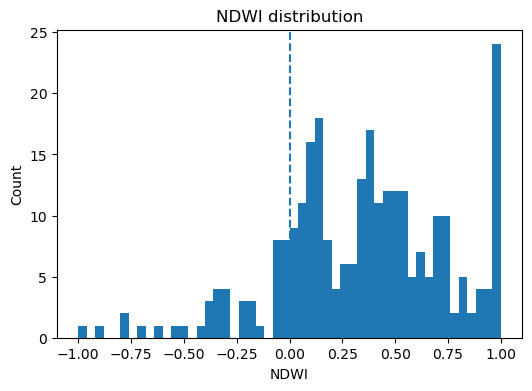

In [20]:
# NDWI 분포 시각화
plt.figure(figsize=(6, 4))
plt.hist(df_loaded["NDWI"].dropna(), bins=50)
plt.axvline(0, linestyle="--")  # water / non-water 기준선
plt.xlabel("NDWI")
plt.ylabel("Count")
plt.title("NDWI distribution")
plt.show()

In [21]:
thresholds = [-0.1, 0.0, 0.1, 0.2]

for t in thresholds:
    print(f"NDWI > {t:>4}: {(df_loaded['NDWI'] > t).sum()}")

NDWI > -0.1: 249
NDWI >  0.0: 232
NDWI >  0.1: 209
NDWI >  0.2: 171


### GEE

In [2]:
import ee
import pandas as pd
import numpy as np
from datetime import timedelta

ee.Initialize()

/home/khs/anaconda3/envs/hoso/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


patch

In [7]:
def dms_to_dd(v):
    try:
        if isinstance(v, (int, float)):
            return float(v)
        s = str(v).strip()
        if re.match(r'^\d+(\.\d+)?$', s):
            return float(s)
        parts = re.split('[°\'"]+', s)
        parts = [p for p in parts if p]
        deg, minute, sec = map(float, parts[:3])
        return deg + minute/60 + sec/3600
    except Exception:
        return None

In [8]:
patch_bands = [
    "B1", "B2", "B3", "B4", "B5", "B6", "B7",
    "B8", "B8A", "B9", "B11", "B12"
]

In [9]:
# Sentinel-2 Surface Reflectance (L2A)
S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

In [49]:
kernel_3x3 = ee.Kernel.square(1, "pixels", False)

patches = []      # (C, 3, 3)
meta_rows = []

df_loaded = df_loaded.reset_index(drop=True)

print("전체 row 수:", len(df_loaded))
print("날짜 개수:", df_loaded["년/월/일"].nunique())
print("-" * 50)

for date_i, (date, group) in enumerate(df_loaded.groupby("년/월/일"), start=1):

    print(f"\n[{date_i}] 날짜: {date} | 관측점 수: {len(group)}")

    obs_date = pd.to_datetime(date)
    start = obs_date.strftime("%Y-%m-%d")
    end   = (obs_date + timedelta(days=1)).strftime("%Y-%m-%d")

    # -----------------------------
    # FeatureCollection 생성
    # -----------------------------
    features = []
    for idx, row in group.iterrows():
        lon = dms_to_dd(row["경도"])
        lat = dms_to_dd(row["위도"])

        if lon is None or lat is None:
            print(f"  - 좌표 변환 실패 idx={idx}")
            continue

        features.append(
            ee.Feature(ee.Geometry.Point([lon, lat]), {"idx": int(idx)})
        )

    print("  → 유효 Feature 수:", len(features))

    if not features:
        print("  → skip (feature 없음)")
        continue

    fc = ee.FeatureCollection(features)

    # -----------------------------
    # Sentinel-2 필터링
    # -----------------------------
    s2_col = S2.filterBounds(fc).filterDate(start, end)
    col_size = s2_col.size().getInfo()
    print("  → Sentinel-2 이미지 수:", col_size)

    if col_size == 0:
        print("  → skip (이미지 없음)")
        continue

    s2_img = s2_col.sort("system:time_start", False).first()

    # -----------------------------
    # SCL 마스킹
    # -----------------------------
    scl = s2_img.select("SCL")
    mask = scl.eq(2).Or(scl.eq(6)).Or(scl.eq(7))
    s2_selected = s2_img.select(patch_bands).updateMask(mask)

    s2_patch = s2_selected.neighborhoodToBands(kernel_3x3)

    # -----------------------------
    # reduceRegions
    # -----------------------------
    try:
        reduced = s2_patch.reduceRegions(
            collection=fc,
            reducer=ee.Reducer.first(),
            scale=10
        ).getInfo()

        print("  → reduceRegions 결과 feature 수:",
              len(reduced["features"]))

        success = 0

        for feat in reduced["features"]:
            props = feat["properties"]
            idx = props.get("idx")

            if props.get("B2_0_0") is None:
                print(f"    - idx {idx}: 중앙픽셀 없음 → skip")
                continue

            # ---------- NumPy 패치 생성 ----------
            patch = []
            for band in patch_bands:
                band_patch = np.array([
                    [props.get(f"{band}_{i}_{j}", np.nan) for j in [-1, 0, 1]]
                    for i in [-1, 0, 1]
                ])
                patch.append(band_patch)

            patch = np.stack(patch)  # (C, 3, 3)

            # sanity check
            if patch.shape != (len(patch_bands), 3, 3):
                print(f"    shape 이상 idx={idx}: {patch.shape}")
                continue

            patches.append(patch)
            meta_rows.append(df_loaded.loc[idx])
            success += 1

        print(f"  → 성공 패치 수: {success}")

    except Exception as e:
        print("   에러 발생:", e)

print("\n--- 모든 날짜 처리 완료 ---")
print("최종 패치 개수:", len(patches))


전체 row 수: 278
날짜 개수: 167
--------------------------------------------------

[1] 날짜: 2018/02/22 | 관측점 수: 1
  → 유효 Feature 수: 1
  → Sentinel-2 이미지 수: 2
  → reduceRegions 결과 feature 수: 1
  → 성공 패치 수: 1

[2] 날짜: 2018/10/15 | 관측점 수: 3
  → 유효 Feature 수: 3
  → Sentinel-2 이미지 수: 1
  → reduceRegions 결과 feature 수: 3
  → 성공 패치 수: 3

[3] 날짜: 2018/12/24 | 관측점 수: 1
  → 유효 Feature 수: 1
  → Sentinel-2 이미지 수: 2
  → reduceRegions 결과 feature 수: 1
  → 성공 패치 수: 1

[4] 날짜: 2019/01/03 | 관측점 수: 3
  → 유효 Feature 수: 3
  → Sentinel-2 이미지 수: 2
  → reduceRegions 결과 feature 수: 3
  → 성공 패치 수: 3

[5] 날짜: 2019/01/08 | 관측점 수: 1
  → 유효 Feature 수: 1
  → Sentinel-2 이미지 수: 1
  → reduceRegions 결과 feature 수: 1
  → 성공 패치 수: 1

[6] 날짜: 2019/01/15 | 관측점 수: 2
  → 유효 Feature 수: 2
  → Sentinel-2 이미지 수: 2
  → reduceRegions 결과 feature 수: 2
  → 성공 패치 수: 2

[7] 날짜: 2019/02/12 | 관측점 수: 3
  → 유효 Feature 수: 3
  → Sentinel-2 이미지 수: 4
  → reduceRegions 결과 feature 수: 3
  → 성공 패치 수: 3

[8] 날짜: 2019/03/04 | 관측점 수: 3
  → 유효 Feature 수: 3
  → S

In [61]:
import numpy as np
import pandas as pd

# -----------------------------
# NumPy 배열로 변환
# -----------------------------
X = np.stack(patches)   # (N, C, 3, 3)
meta_df = pd.DataFrame(meta_rows).reset_index(drop=True)

print("X shape:", X.shape)
print("meta_df shape:", meta_df.shape)

# -----------------------------
# 저장 경로
# -----------------------------
save_path = "/home/khs/data/csv/matching data/npy/s2_patch_3x3.npz"

np.savez_compressed(
    save_path,
    X=X,
    meta=meta_df.to_numpy(),
    meta_columns=meta_df.columns.to_numpy()
)

print("저장 완료:", save_path)


X shape: (278, 12, 3, 3)
meta_df shape: (278, 154)
저장 완료: /home/khs/data/csv/matching data/npy/s2_patch_3x3.npz


CNN

In [10]:
import numpy as np
import pandas as pd

load_path = "/home/khs/data/csv/matching data/npy/s2_patch_3x3.npz"

loaded = np.load(load_path, allow_pickle=True)

X = loaded["X"]                       # (N, C, 3, 3)
meta_df = pd.DataFrame(
    loaded["meta"],
    columns=loaded["meta_columns"]
)

print("불러온 X shape:", X.shape)
print("불러온 meta_df shape:", meta_df.shape)

meta_df


불러온 X shape: (278, 12, 3, 3)
불러온 meta_df shape: (278, 154)


,년/월/일,측정소명,분류번호,회차,경도,위도,채수시각,수온(℃),클로로필 a(㎎/㎥),투명도(m),...,B9_1_1,SCL_-1_-1,SCL_-1_0,SCL_-1_1,SCL_0_-1,SCL_0_0,SCL_0_1,SCL_1_-1,SCL_1_0,SCL_1_1
0,2018/02/22,나주댐1,5003B20,1회차 상층부,126.86,34.956219,11:07,2.9,9.3,2.5,...,195.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
1,2018/10/15,남강댐1(진양호),2018B30,1회차 상층부,128.031639,35.168,09:30,17.7,4.5,0.6,...,0.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
2,2018/10/15,남강댐2(진양호),2018B20,1회차 상층부,127.987528,35.154889,09:00,18.0,4.3,0.6,...,0.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
3,2018/10/15,남강댐3(진양호),2018B10,1회차 상층부,127.977333,35.206694,10:00,17.8,5.4,0.6,...,8.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
4,2018/12/24,충주댐1,1003B40,4회차 상층부,127.996497,37.0007,14:55,10.0,1.1,2.5,...,75.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2025/10/15,밀양댐1,2021B40,1회차 상층부,128.932028,35.481444,10:30,22.4,19.6,2.5,...,1183.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
274,2025/10/20,주암댐1,4007B70,2회차 상층부,127.240761,35.056606,10:39,22.7,8.3,3.2,...,89.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
275,2025/10/23,나주댐1,5003B20,1회차 상층부,126.86,34.956219,11:04,21.7,5.7,1.3,...,35.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0
276,2025/10/23,나주댐2,5003B10,1회차 상층부,126.8487,34.9276,11:15,22.1,9.5,1.5,...,4.0,6.0,6.0,6.0,6,6,6.0,6.0,6.0,6.0


In [11]:
# Sentinel-2 band scaling
# X = X.astype("float32") / 10000.0
print("X shape:", X.shape)
X[0]

X shape: (278, 12, 3, 3)


array([[[244, 244, 244],
        [244, 244, 244],
        [244, 244, 244]],

       [[320, 318, 316],
        [316, 292, 324],
        [344, 329, 342]],

       [[332, 323, 324],
        [342, 333, 322],
        [317, 304, 316]],

       [[256, 247, 244],
        [245, 245, 256],
        [253, 257, 257]],

       [[238, 232, 232],
        [243, 239, 239],
        [243, 239, 239]],

       [[227, 229, 229],
        [226, 225, 225],
        [226, 225, 225]],

       [[233, 234, 234],
        [233, 243, 243],
        [233, 243, 243]],

       [[249, 252, 247],
        [249, 249, 249],
        [253, 248, 253]],

       [[221, 222, 222],
        [219, 220, 220],
        [219, 220, 220]],

       [[195, 195, 195],
        [195, 195, 195],
        [195, 195, 195]],

       [[180, 177, 177],
        [183, 188, 188],
        [183, 188, 188]],

       [[146, 143, 143],
        [144, 139, 139],
        [144, 139, 139]]], dtype=object)

In [12]:
import numpy as np

# =========================
# 1. NDWI 계산 (중앙 픽셀)
# =========================
# Sentinel-2 band index 기준
# B3 (Green) = index 2
# B8 (NIR)   = index 7

B3_idx = 2
B8_idx = 7

green = X[:, B3_idx, 1, 1]   # 중앙 픽셀
nir   = X[:, B8_idx, 1, 1]

ndwi = (green - nir) / (green + nir + 1e-6)

print("NDWI 통계")
print("  min :", np.nanmin(ndwi))
print("  max :", np.nanmax(ndwi))
print("  mean:", np.nanmean(ndwi))


# =========================
# 2. NDWI threshold 적용
# =========================
ndwi_thresh = 0.0   # 댐/호소 논문에서 가장 흔함
ndwi_mask = ndwi > ndwi_thresh

print(f"NDWI > {ndwi_thresh} 통과 샘플 수:",
      ndwi_mask.sum(), "/", len(ndwi_mask))


# =========================
# 3. X, meta_df 함께 필터링
# =========================
X = X[ndwi_mask]
meta_df = meta_df.loc[ndwi_mask].reset_index(drop=True)

print("NDWI 적용 후")
print("X shape:", X.shape)
print("meta_df shape:", meta_df.shape)

NDWI 통계
  min : -0.9999998333333611
  max : 0.9999999983416252
  mean: 0.34488980376835787
NDWI > 0.0 통과 샘플 수: 232 / 278
NDWI 적용 후
X shape: (232, 12, 3, 3)
meta_df shape: (232, 154)


In [13]:
temp = meta_df["temp_surface"].values.astype("float32")      # (N,)
secchi = meta_df["secchi_surface"].values.astype("float32")  # (N,)

N = X.shape[0]

temp_patch = np.repeat(temp[:, None, None], 3, axis=1)
temp_patch = np.repeat(temp_patch, 3, axis=2)
temp_patch = temp_patch[:, None, :, :]   # (N, 1, 3, 3)

secchi_patch = np.repeat(secchi[:, None, None], 3, axis=1)
secchi_patch = np.repeat(secchi_patch, 3, axis=2)
secchi_patch = secchi_patch[:, None, :, :]  # (N, 1, 3, 3)

X = np.concatenate(
    [X, temp_patch, secchi_patch],
    axis=1
)

print("확장된 X shape:", X.shape)


확장된 X shape: (232, 14, 3, 3)


In [14]:
import numpy as np

# X: (N, C, 3, 3)
X = X.astype("float32")

N, C, H, W = X.shape

channel_means = np.zeros(C, dtype=np.float32)
channel_stds  = np.zeros(C, dtype=np.float32)

for c in range(C):
    ch = X[:, c, :, :]               # (N, 3, 3)

    mean = np.nanmean(ch)
    std  = np.nanstd(ch)

    # 안전장치 (std=0 방지)
    if std == 0:
        std = 1.0

    X[:, c, :, :] = (ch - mean) / std

    channel_means[c] = mean
    channel_stds[c]  = std

print(" 채널별 Z-score 정규화 완료")
print("X shape:", X.shape)

 채널별 Z-score 정규화 완료
X shape: (232, 14, 3, 3)


In [15]:
# 타깃
y = meta_df[[
    "chla_surface",
    "chla_mid",
    "chla_bottom"
]].to_numpy(dtype=np.float32)

print("y shape:", y.shape)  # (N, 3)


y shape: (232, 3)


In [16]:
import torch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(X_tensor.shape)  # (N, C, 3, 3)
print(y_tensor.shape)  # (N, 3)


torch.Size([232, 14, 3, 3])
torch.Size([232, 3])


CNN

In [17]:
import torch.nn.functional as F

class CNN2DRegressor(nn.Module):
    def __init__(self, in_channels, out_dim=3, dropout=0.3, fc_dim=64):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # 3×3 → 그대로 유지
        self.flatten = nn.Flatten()

        # feature size 자동 계산
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, 3, 3)
            feat_dim = self._forward_features(dummy).shape[1]

        self.fc1 = nn.Linear(feat_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, out_dim)

    def _forward_features(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [23]:
print("X NaN:", torch.isnan(X_tensor).any())
print("X Inf:", torch.isinf(X_tensor).any())

print("y NaN:", torch.isnan(y_tensor).any())
print("y Inf:", torch.isinf(y_tensor).any())

X NaN: tensor(True, device='cuda:0')
X Inf: tensor(False, device='cuda:0')
y NaN: tensor(False, device='cuda:0')
y Inf: tensor(False, device='cuda:0')


In [18]:
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

X_tensor = X_tensor.to(device)   # (N, C, 3, 3)
y_tensor = y_tensor.to(device)   # (N, 3)

# train / val split
from sklearn.model_selection import train_test_split

X_tr, X_va, y_tr, y_va = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

train_ds = TensorDataset(X_tr, y_tr)
val_ds   = TensorDataset(X_va, y_va)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


In [19]:
import optuna
import torch.optim as optim

def objective(trial):

    #  탐색 공간
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    fc_dim  = trial.suggest_categorical("fc_dim", [32, 64, 128])
    lr      = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    opt_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    model = CNN2DRegressor(
        in_channels=X_tensor.shape[1],
        out_dim=y_tensor.shape[1],
        dropout=dropout,
        fc_dim=fc_dim
    ).to(device)

    optimizer = (
        optim.Adam(model.parameters(), lr=lr)
        if opt_name == "Adam"
        else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    )

    criterion = nn.MSELoss()

    # 학습
    for epoch in range(30):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_loss += criterion(pred, yb).item()

        val_loss /= len(val_loader)

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best val loss:", study.best_value)

[I 2026-01-23 09:22:47,052] A new study created in memory with name: no-name-dbebb472-36ad-4d32-b1f8-b2515c0f9b44
[W 2026-01-23 09:22:47,492] Trial 0 failed with parameters: {'dropout': 0.3670028630738096, 'fc_dim': 64, 'lr': 0.0007187518477058883, 'optimizer': 'SGD'} because of the following error: The value nan is not acceptable.
[W 2026-01-23 09:22:47,493] Trial 0 failed with value nan.
[W 2026-01-23 09:22:47,979] Trial 1 failed with parameters: {'dropout': 0.3350847381290192, 'fc_dim': 128, 'lr': 0.003665142787505046, 'optimizer': 'Adam'} because of the following error: The value nan is not acceptable.
[W 2026-01-23 09:22:47,980] Trial 1 failed with value nan.
[W 2026-01-23 09:22:48,460] Trial 2 failed with parameters: {'dropout': 0.22256820647641168, 'fc_dim': 32, 'lr': 0.007641227482430178, 'optimizer': 'Adam'} because of the following error: The value nan is not acceptable.
[W 2026-01-23 09:22:48,462] Trial 2 failed with value nan.
[W 2026-01-23 09:22:48,911] Trial 3 failed with

ValueError: No trials are completed yet.

In [ ]:
best = study.best_params

model = CNN2DRegressor(
    in_channels=X_tensor.shape[1],
    out_dim=y_tensor.shape[1],
    dropout=best["dropout"],
    fc_dim=best["fc_dim"]
).to(device)

optimizer = (
    optim.Adam(model.parameters(), lr=best["lr"])
    if best["optimizer"] == "Adam"
    else optim.SGD(model.parameters(), lr=best["lr"], momentum=0.9)
)

criterion = nn.MSELoss()

EPOCHS = 200
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"[{epoch+1}/{EPOCHS}] loss={loss.item():.4f}")


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ---------------------------
# Best hyperparameters
# ---------------------------
best = study.best_params
print("Best params:", best)

model = CNN2DRegressor(
    in_channels=X_tensor.shape[1],
    out_dim=y_tensor.shape[1],
    dropout=best["dropout"],
    fc_dim=best["fc_dim"]
).to(device)

optimizer = (
    optim.Adam(model.parameters(), lr=best["lr"])
    if best["optimizer"] == "Adam"
    else optim.SGD(model.parameters(), lr=best["lr"], momentum=0.9)
)

criterion = nn.MSELoss()

# ---------------------------
# Training
# ---------------------------
EPOCHS = 200

train_mse_list = []
val_mse_list = []
train_rmse_list = []
val_rmse_list = []

for epoch in range(EPOCHS):

    # ===== Train =====
    model.train()
    train_mse = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        train_mse += loss.item()

    train_mse /= len(train_loader)
    train_rmse = np.sqrt(train_mse)

    # ===== Validation =====
    model.eval()
    val_mse = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_mse += criterion(pred, yb).item()

    val_mse /= len(val_loader)
    val_rmse = np.sqrt(val_mse)

    # 기록
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)

    # 출력
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(
            f"[{epoch+1:03d}/{EPOCHS}] "
            f"Train MSE: {train_mse:.4f} | Train RMSE: {train_rmse:.4f} || "
            f"Val MSE: {val_mse:.4f} | Val RMSE: {val_rmse:.4f}"
        )

print("\n Training finished")
print(f"Final Val RMSE: {val_rmse_list[-1]:.4f}")


ValueError: No trials are completed yet.